# FACE RECOGNITION MODEL TRAIN

## Imports

In [ ]:
!git clone https://github.com/clcarwin/sphereface_pytorch.git &> /dev/null
%cd sphereface_pytorch/
!7za x model/sphere20a_20171020.7z -omodel
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

/content/sphereface_pytorch

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 14999693 bytes (15 MiB)

Extracting archive: model/sphere20a_20171020.7z
--
Path = model/sphere20a_20171020.7z
Type = 7z
Physical Size = 14999693
Headers Size = 146
Method = LZMA:25
Solid = -
Blocks = 1

  0%     11% - sphere20a_20171020.pth                              14% - sphere20a_20171020.pth                              18% - sphere20a_20171020.pth                              22% - sphere20a_20171020.pth                              26% - sp

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import dlib
import numpy as np
import PIL
import io
import html
import time
import torch
import torch.nn as nn
from net_sphere import sphere20a
from torchvision.datasets.lfw import LFWPairs
from torchvision.transforms import Resize, Lambda, Compose
import numpy as np
from numpy.linalg import inv, norm, lstsq
from numpy.linalg import matrix_rank as rank
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 11 06:54:28 2017

@author: zhaoyafei
"""

r"""
Introduction:
----------
numpy implemetation form matlab function CP2TFORM(...)
with 'transformtype':
    1) 'nonreflective similarity'
    2) 'similarity'


MATLAB code:
----------
%--------------------------------------
% Function  findNonreflectiveSimilarity
%
function [trans, output] = findNonreflectiveSimilarity(uv,xy,options)
%
% For a nonreflective similarity:
%
% let sc = s*cos(theta)
% let ss = s*sin(theta)
%
%                   [ sc -ss
% [u v] = [x y 1] *   ss  sc
%                     tx  ty]
%
% There are 4 unknowns: sc,ss,tx,ty.
%
% Another way to write this is:
%
% u = [x y 1 0] * [sc
%                  ss
%                  tx
%                  ty]
%
% v = [y -x 0 1] * [sc
%                   ss
%                   tx
%                   ty]
%
% With 2 or more correspondence points we can combine the u equations and
% the v equations for one linear system to solve for sc,ss,tx,ty.
%
% [ u1  ] = [ x1  y1  1  0 ] * [sc]
% [ u2  ]   [ x2  y2  1  0 ]   [ss]
% [ ... ]   [ ...          ]   [tx]
% [ un  ]   [ xn  yn  1  0 ]   [ty]
% [ v1  ]   [ y1 -x1  0  1 ]
% [ v2  ]   [ y2 -x2  0  1 ]
% [ ... ]   [ ...          ]
% [ vn  ]   [ yn -xn  0  1 ]
%
% Or rewriting the above matrix equation:
% U = X * r, where r = [sc ss tx ty]'
% so r = X\U.
%

K = options.K;
M = size(xy,1);
x = xy(:,1);
y = xy(:,2);
X = [x   y  ones(M,1)   zeros(M,1);
     y  -x  zeros(M,1)  ones(M,1)  ];

u = uv(:,1);
v = uv(:,2);
U = [u; v];

% We know that X * r = U
if rank(X) >= 2*K
    r = X \ U;
else
    error(message('images:cp2tform:twoUniquePointsReq'))
end

sc = r(1);
ss = r(2);
tx = r(3);
ty = r(4);

Tinv = [sc -ss 0;
        ss  sc 0;
        tx  ty 1];

T = inv(Tinv);
T(:,3) = [0 0 1]';

trans = maketform('affine', T);
output = [];

%-------------------------
% Function  findSimilarity
%
function [trans, output] = findSimilarity(uv,xy,options)
%
% The similarities are a superset of the nonreflective similarities as they may
% also include reflection.
%
% let sc = s*cos(theta)
% let ss = s*sin(theta)
%
%                   [ sc -ss
% [u v] = [x y 1] *   ss  sc
%                     tx  ty]
%
%          OR
%
%                   [ sc  ss
% [u v] = [x y 1] *   ss -sc
%                     tx  ty]
%
% Algorithm:
% 1) Solve for trans1, a nonreflective similarity.
% 2) Reflect the xy data across the Y-axis,
%    and solve for trans2r, also a nonreflective similarity.
% 3) Transform trans2r to trans2, undoing the reflection done in step 2.
% 4) Use TFORMFWD to transform uv using both trans1 and trans2,
%    and compare the results, Returnsing the transformation corresponding
%    to the smaller L2 norm.

% Need to reset options.K to prepare for calls to findNonreflectiveSimilarity.
% This is safe because we already checked that there are enough point pairs.
options.K = 2;

% Solve for trans1
[trans1, output] = findNonreflectiveSimilarity(uv,xy,options);


% Solve for trans2

% manually reflect the xy data across the Y-axis
xyR = xy;
xyR(:,1) = -1*xyR(:,1);

trans2r  = findNonreflectiveSimilarity(uv,xyR,options);

% manually reflect the tform to undo the reflection done on xyR
TreflectY = [-1  0  0;
              0  1  0;
              0  0  1];
trans2 = maketform('affine', trans2r.tdata.T * TreflectY);


% Figure out if trans1 or trans2 is better
xy1 = tformfwd(trans1,uv);
norm1 = norm(xy1-xy);

xy2 = tformfwd(trans2,uv);
norm2 = norm(xy2-xy);

if norm1 <= norm2
    trans = trans1;
else
    trans = trans2;
end
"""

class MatlabCp2tormException(Exception):
    def __str__(self):
        return 'In File {}:{}'.format(
                __file__, super.__str__(self))

def tformfwd(trans, uv):
    """
    Function:
    ----------
        apply affine transform 'trans' to uv

    Parameters:
    ----------
        @trans: 3x3 np.array
            transform matrix
        @uv: Kx2 np.array
            each row is a pair of coordinates (x, y)

    Returns:
    ----------
        @xy: Kx2 np.array
            each row is a pair of transformed coordinates (x, y)
    """
    uv = np.hstack((
        uv, np.ones((uv.shape[0], 1))
    ))
    xy = np.dot(uv, trans)
    xy = xy[:, 0:-1]
    return xy


def tforminv(trans, uv):
    """
    Function:
    ----------
        apply the inverse of affine transform 'trans' to uv

    Parameters:
    ----------
        @trans: 3x3 np.array
            transform matrix
        @uv: Kx2 np.array
            each row is a pair of coordinates (x, y)

    Returns:
    ----------
        @xy: Kx2 np.array
            each row is a pair of inverse-transformed coordinates (x, y)
    """
    Tinv = inv(trans)
    xy = tformfwd(Tinv, uv)
    return xy


def findNonreflectiveSimilarity(uv, xy, options=None):
    r"""
    Function:
    ----------
        Find Non-reflective Similarity Transform Matrix 'trans':
            u = uv[:, 0]
            v = uv[:, 1]
            x = xy[:, 0]
            y = xy[:, 1]
            [x, y, 1] = [u, v, 1] * trans

    Parameters:
    ----------
        @uv: Kx2 np.array
            source points each row is a pair of coordinates (x, y)
        @xy: Kx2 np.array
            each row is a pair of inverse-transformed
        @option: not used, keep it as None

    Returns:
        @trans: 3x3 np.array
            transform matrix from uv to xy
        @trans_inv: 3x3 np.array
            inverse of trans, transform matrix from xy to uv

    Matlab:
    ----------
    % For a nonreflective similarity:
    %
    % let sc = s*cos(theta)
    % let ss = s*sin(theta)
    %
    %                   [ sc -ss
    % [u v] = [x y 1] *   ss  sc
    %                     tx  ty]
    %
    % There are 4 unknowns: sc,ss,tx,ty.
    %
    % Another way to write this is:
    %
    % u = [x y 1 0] * [sc
    %                  ss
    %                  tx
    %                  ty]
    %
    % v = [y -x 0 1] * [sc
    %                   ss
    %                   tx
    %                   ty]
    %
    % With 2 or more correspondence points we can combine the u equations and
    % the v equations for one linear system to solve for sc,ss,tx,ty.
    %
    % [ u1  ] = [ x1  y1  1  0 ] * [sc]
    % [ u2  ]   [ x2  y2  1  0 ]   [ss]
    % [ ... ]   [ ...          ]   [tx]
    % [ un  ]   [ xn  yn  1  0 ]   [ty]
    % [ v1  ]   [ y1 -x1  0  1 ]
    % [ v2  ]   [ y2 -x2  0  1 ]
    % [ ... ]   [ ...          ]
    % [ vn  ]   [ yn -xn  0  1 ]
    %
    % Or rewriting the above matrix equation:
    % U = X * r, where r = [sc ss tx ty]'
    % so r = X\U.
    %
    """
    options = {'K': 2}

    K = options['K']
    M = xy.shape[0]
    x = xy[:, 0].reshape((-1, 1))  # use reshape to keep a column vector
    y = xy[:, 1].reshape((-1, 1))  # use reshape to keep a column vector
    # print('--->x, y:\n', x, y)

    tmp1 = np.hstack((x, y, np.ones((M, 1)), np.zeros((M, 1))))
    tmp2 = np.hstack((y, -x, np.zeros((M, 1)), np.ones((M, 1))))
    X = np.vstack((tmp1, tmp2))
    # print('--->X.shape: ', X.shape)
    # print('X:\n', X)

    u = uv[:, 0].reshape((-1, 1))  # use reshape to keep a column vector
    v = uv[:, 1].reshape((-1, 1))  # use reshape to keep a column vector
    U = np.vstack((u, v))
    # print('--->U.shape: ', U.shape)
    # print('U:\n', U)

    # We know that X * r = U
    if rank(X) >= 2 * K:
        r, _, _, _ = lstsq(X, U)
        r = np.squeeze(r)
    else:
        raise Exception('cp2tform:twoUniquePointsReq')

    # print('--->r:\n', r)

    sc = r[0]
    ss = r[1]
    tx = r[2]
    ty = r[3]

    Tinv = np.array([
        [sc, -ss, 0],
        [ss,  sc, 0],
        [tx,  ty, 1]
    ])

    # print('--->Tinv:\n', Tinv)

    T = inv(Tinv)
    # print('--->T:\n', T)

    T[:, 2] = np.array([0, 0, 1])

    return T, Tinv


def findSimilarity(uv, xy, options=None):
    """
    Function:
    ----------
        Find Reflective Similarity Transform Matrix 'trans':
            u = uv[:, 0]
            v = uv[:, 1]
            x = xy[:, 0]
            y = xy[:, 1]
            [x, y, 1] = [u, v, 1] * trans

    Parameters:
    ----------
        @uv: Kx2 np.array
            source points each row is a pair of coordinates (x, y)
        @xy: Kx2 np.array
            each row is a pair of inverse-transformed
        @option: not used, keep it as None

    Returns:
    ----------
        @trans: 3x3 np.array
            transform matrix from uv to xy
        @trans_inv: 3x3 np.array
            inverse of trans, transform matrix from xy to uv

    Matlab:
    ----------
    % The similarities are a superset of the nonreflective similarities as they may
    % also include reflection.
    %
    % let sc = s*cos(theta)
    % let ss = s*sin(theta)
    %
    %                   [ sc -ss
    % [u v] = [x y 1] *   ss  sc
    %                     tx  ty]
    %
    %          OR
    %
    %                   [ sc  ss
    % [u v] = [x y 1] *   ss -sc
    %                     tx  ty]
    %
    % Algorithm:
    % 1) Solve for trans1, a nonreflective similarity.
    % 2) Reflect the xy data across the Y-axis,
    %    and solve for trans2r, also a nonreflective similarity.
    % 3) Transform trans2r to trans2, undoing the reflection done in step 2.
    % 4) Use TFORMFWD to transform uv using both trans1 and trans2,
    %    and compare the results, Returnsing the transformation corresponding
    %    to the smaller L2 norm.

    % Need to reset options.K to prepare for calls to findNonreflectiveSimilarity.
    % This is safe because we already checked that there are enough point pairs.
    """
    options = {'K': 2}

#    uv = np.array(uv)
#    xy = np.array(xy)

    # Solve for trans1
    trans1, trans1_inv = findNonreflectiveSimilarity(uv, xy, options)

    # Solve for trans2

    # manually reflect the xy data across the Y-axis
    xyR = xy
    xyR[:, 0] = -1 * xyR[:, 0]

    trans2r, trans2r_inv = findNonreflectiveSimilarity(uv, xyR, options)

    # manually reflect the tform to undo the reflection done on xyR
    TreflectY = np.array([
        [-1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])

    trans2 = np.dot(trans2r, TreflectY)

    # Figure out if trans1 or trans2 is better
    xy1 = tformfwd(trans1, uv)
    norm1 = norm(xy1 - xy)

    xy2 = tformfwd(trans2, uv)
    norm2 = norm(xy2 - xy)

    if norm1 <= norm2:
        return trans1, trans1_inv
    else:
        trans2_inv = inv(trans2)
        return trans2, trans2_inv


def get_similarity_transform(src_pts, dst_pts, reflective=True):
    """
    Function:
    ----------
        Find Similarity Transform Matrix 'trans':
            u = src_pts[:, 0]
            v = src_pts[:, 1]
            x = dst_pts[:, 0]
            y = dst_pts[:, 1]
            [x, y, 1] = [u, v, 1] * trans

    Parameters:
    ----------
        @src_pts: Kx2 np.array
            source points, each row is a pair of coordinates (x, y)
        @dst_pts: Kx2 np.array
            destination points, each row is a pair of transformed
            coordinates (x, y)
        @reflective: True or False
            if True:
                use reflective similarity transform
            else:
                use non-reflective similarity transform

    Returns:
    ----------
       @trans: 3x3 np.array
            transform matrix from uv to xy
        trans_inv: 3x3 np.array
            inverse of trans, transform matrix from xy to uv
    """

    if reflective:
        trans, trans_inv = findSimilarity(src_pts, dst_pts)
    else:
        trans, trans_inv = findNonreflectiveSimilarity(src_pts, dst_pts)

    return trans, trans_inv


def cvt_tform_mat_for_cv2(trans):
    """
    Function:
    ----------
        Convert Transform Matrix 'trans' into 'cv2_trans' which could be
        directly used by cv2.warpAffine():
            u = src_pts[:, 0]
            v = src_pts[:, 1]
            x = dst_pts[:, 0]
            y = dst_pts[:, 1]
            [x, y].T = cv_trans * [u, v, 1].T

    Parameters:
    ----------
        @trans: 3x3 np.array
            transform matrix from uv to xy

    Returns:
    ----------
        @cv2_trans: 2x3 np.array
            transform matrix from src_pts to dst_pts, could be directly used
            for cv2.warpAffine()
    """
    cv2_trans = trans[:, 0:2].T

    return cv2_trans


def get_similarity_transform_for_cv2(src_pts, dst_pts, reflective=True):
    """
    Function:
    ----------
        Find Similarity Transform Matrix 'cv2_trans' which could be
        directly used by cv2.warpAffine():
            u = src_pts[:, 0]
            v = src_pts[:, 1]
            x = dst_pts[:, 0]
            y = dst_pts[:, 1]
            [x, y].T = cv_trans * [u, v, 1].T

    Parameters:
    ----------
        @src_pts: Kx2 np.array
            source points, each row is a pair of coordinates (x, y)
        @dst_pts: Kx2 np.array
            destination points, each row is a pair of transformed
            coordinates (x, y)
        reflective: True or False
            if True:
                use reflective similarity transform
            else:
                use non-reflective similarity transform

    Returns:
    ----------
        @cv2_trans: 2x3 np.array
            transform matrix from src_pts to dst_pts, could be directly used
            for cv2.warpAffine()
    """
    trans, trans_inv = get_similarity_transform(src_pts, dst_pts, reflective)
    cv2_trans = cvt_tform_mat_for_cv2(trans)

    return cv2_trans


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Face detection

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
        bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def dlib2array(dlib_rect):
  """
  Params:
        dlib_rect: dlib.rectangle containing the rectangle coordinates (tl) and (br)
  Returns:
        x,y,w,h: int rectangle coordinates x, y, width, and height
  """
  x = dlib_rect.left()
  y = dlib_rect.top()
  w = dlib_rect.right() - dlib_rect.left()
  h = dlib_rect.bottom() - dlib_rect.top()
  return x, y, w, h

In [ ]:
# initialize the dlib face detection model
face_detector = dlib.get_frontal_face_detector()


In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
past_face = None
while True:

    js_reply = video_frame(label_html, bbox)

    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # get face region coordinates
    faces, scores, _ = face_detector.run(img, 1, -1)

    if len(scores) != 0:
      score = max(scores)

      if score >= 0.3:
        print("Faccia trovata!!")
      # get face bounding box for overlay
      print("Score: {}".format(score))


## Dataset construction

In [ ]:
# Images paths
pivaz_path = '/content/drive/MyDrive/machine learning/ICT/PROJECT ICT PPPP/foto piva'
martinez_path = '/content/drive/MyDrive/machine learning/ICT/PROJECT ICT PPPP/foto martin'
unknown_path = '/content/drive/MyDrive/machine learning/ICT/PROJECT ICT PPPP/foto sconosciuti'

In [ ]:
# Organize the images in lists
pivaz_images_pre = []
martinez_images_pre = []
unknown_images_pre = []

for filename in os.listdir(pivaz_path):
  if filename.endswith('.jpg'):
    img = cv2.imread(os.path.join(pivaz_path, filename))
    if img is not None:
      pivaz_images_pre.append(img)

for filename in os.listdir(martinez_path):
  if filename.endswith('.jpg'):
    img = cv2.imread(os.path.join(martinez_path, filename))
    if img is not None:
      martinez_images_pre.append(img)

for filename in os.listdir(unknown_path):
  if filename.endswith('.jpg'):
    img = cv2.imread(os.path.join(unknown_path, filename))
    if img is not None:
      unknown_images_pre.append(img)

# extract 50 random images
unknown_images_pre = random.sample(unknown_images_pre, 115)

In [ ]:
# Print and check the results
print(len(pivaz_images_pre))
print(len(martinez_images_pre))
print(len(unknown_images_pre))

115
115
115


In [ ]:
# Face alignment class

class FaceAligner:
    def __init__(self, desired_left_eye=(0.35, 0.35), desired_face_width=112, desired_face_height=96):
        """
        Initialize the face aligner object
        :param desired_left_eye: Relative position of the left eye in the aligned image
        :param desired_face_width: Width of the output face image
        :param desired_face_height: Height of the output face image
        """
        self.desired_left_eye = desired_left_eye
        self.desired_face_width = desired_face_width
        self.desired_face_height = desired_face_height

        # Calculate the desired right eye position based on the left eye position
        self.desired_right_eye_x = 1.0 - desired_left_eye[0]

        # Initialize the facial landmark predictor
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    def align(self, image, face_rect):
        """
        Align the face in the image using facial landmarks
        :param image: Input image
        :param face_rect: dlib rectangle containing the face
        :return: Aligned face image
        """
        # Get facial landmarks
        landmarks = self.predictor(image, face_rect)
        landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])

        # Extract the left and right eye coordinates
        left_eye = landmarks[36:42].mean(axis=0).astype("int")
        right_eye = landmarks[42:48].mean(axis=0).astype("int")

        # Calculate angle between eyes
        dY = right_eye[1] - left_eye[1]
        dX = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dY, dX))

        # Calculate the desired right eye coordinate
        desired_right_eye_x = 1.0 - self.desired_left_eye[0]

        # Calculate scaling factor
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desired_dist = (desired_right_eye_x - self.desired_left_eye[0]) * self.desired_face_width
        scale = desired_dist / dist

        # Calculate eyes center point
        eyes_center = (float(left_eye[0] + right_eye[0]) / 2,
               float(left_eye[1] + right_eye[1]) / 2)

        # Create rotation matrix
        M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

        # Update the translation component of the matrix
        tX = self.desired_face_width * 0.5
        tY = self.desired_face_height * self.desired_left_eye[1]
        M[0, 2] += (tX - eyes_center[0])
        M[1, 2] += (tY - eyes_center[1])

        # Apply affine transformation
        aligned_face = cv2.warpAffine(image, M, (self.desired_face_width, self.desired_face_height),
                                    flags=cv2.INTER_CUBIC)

        return aligned_face


In [ ]:
def preprocess_images_with_landmarks(images, face_detector, face_aligner):
    """
    Preprocess a list of images using face landmarks for alignment

    Args:
    images (list): List of OpenCV images
    face_detector: dlib face detector
    face_aligner: FaceAligner instance

    Returns:
    list: Preprocessed and aligned images
    """
    processed_images = []

    for image in images:
        # Detect faces
        faces, scores, _ = face_detector.run(image, 1, -1)
        if len(faces) == 0:
            continue  # Skip images without detected faces

        # Get face with highest confidence score
        face_idx = np.argmax(scores)
        face_rect = faces[face_idx]

        # Align face
        aligned_face = face_aligner.align(image, face_rect)

        if aligned_face is None:
            continue

        # Convert to tensor and normalize
        processed_image = aligned_face / 255.0
        processed_image = torch.tensor(processed_image, dtype=torch.float32).unsqueeze(0)
        processed_image = processed_image.permute(0, 3, 1, 2)

        processed_images.append(processed_image.to(device))

    return processed_images


In [ ]:
face_aligner = FaceAligner()

# Compute pre-processing of the images
pivaz_images = preprocess_images_with_landmarks(pivaz_images_pre, face_detector, face_aligner)
martinez_images = preprocess_images_with_landmarks(martinez_images_pre, face_detector, face_aligner)
unknown_images = preprocess_images_with_landmarks(unknown_images_pre, face_detector, face_aligner)

In [ ]:
# Check results
print(len(pivaz_images))
print(len(martinez_images))
print(len(unknown_images))

115
115
115


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img = row['image']
        label = row['label']

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
pivaz_labels = [1] * len(pivaz_images)
martinez_labels = [2] * len(martinez_images)
unknown_labels = [0] * len(unknown_images)

# Combine all data into a single DataFrame
images = pivaz_images + martinez_images + unknown_images
labels = pivaz_labels + martinez_labels + unknown_labels
print(len(images))
print(len(labels))

data = pd.DataFrame({'image': images, 'label': labels})

# Train/Test/Val split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, stratify=train_data['label'], random_state=42)

train_dataset = ImageDataset(train_data)
val_dataset = ImageDataset(val_data)
test_dataset = ImageDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Print and check the results
print(f"Training data: {len(train_dataset)} samples")
print(f"Validation data: {len(val_dataset)} samples")
print(f"Testing data: {len(test_dataset)} samples")


345
345
Training data: 248 samples
Validation data: 28 samples
Testing data: 69 samples


## Sphereface model definition

In [ ]:
model = sphere20a()
model.load_state_dict(torch.load("/content/sphereface_pytorch/model/sphere20a_20171020.pth"))

# Freeze layers
for param in model.parameters():
    param.requires_grad = False

# Pre-last layer modification
model.fc5 = torch.nn.Linear(model.fc5.in_features, 64)

# Unfreeze pre-last layers (fc5)
for param in model.fc5.parameters():
    param.requires_grad = True

# Last layer modification
model.fc6 = torch.nn.Linear(64, 3)

# Unfreeze last layer (fc6)
for param in model.fc6.parameters():
    param.requires_grad = True

model

<ipython-input-20-48d0231a8968>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/sphereface_pytorch/model/sphere20a_20171020.pth")

sphere20a(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu1_1): PReLU(num_parameters=64)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): PReLU(num_parameters=64)
  (conv1_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_3): PReLU(num_parameters=64)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2_1): PReLU(num_parameters=128)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): PReLU(num_parameters=128)
  (conv2_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_3): PReLU(num_parameters=128)
  (conv2_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_4): PReLU(num_parameters=128)
  (conv2_5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_5): PReLU(num_parameters=128)
  (conv3_1): Conv2d(128, 256, kernel_siz

## Train and test

In [ ]:
# TRAINING

num_epochs = 10
lr = 0.0001

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    count = 0

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )

    # Training loop
    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        # Training phase
        for i, (samples, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            samples, labels = samples.to(device), labels.to(device)

            optimizer.zero_grad()

            samples = samples.squeeze(1)
            samples = samples.contiguous().view(-1, 3, 96, 112)

            outputs = model(samples)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        # Validation phase at end of epoch
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for samples, labels in val_loader:
                samples, labels = samples.to(device), labels.to(device)

                samples = samples.squeeze(1)
                samples = samples.contiguous().view(-1, 3, 96, 112)
                outputs = model(samples)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {100 * correct / total:.2f}%")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/machine learning/ICT/PROJECT ICT PPPP/video_model.pth')
            count = 0
        else:
            count += 1

        if count == 3:
            print("Early stopping triggered!")
            break

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return model


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|██████████| 31/31 [00:20<00:00,  1.48it/s]


Epoch [1/10] Train Loss: 0.7118, Val Loss: 0.4872, Val Accuracy: 82.14%


Epoch 2/10: 100%|██████████| 31/31 [00:19<00:00,  1.63it/s]


Epoch [2/10] Train Loss: 0.3002, Val Loss: 0.3234, Val Accuracy: 85.71%


Epoch 3/10: 100%|██████████| 31/31 [00:19<00:00,  1.61it/s]


Epoch [3/10] Train Loss: 0.1857, Val Loss: 0.2771, Val Accuracy: 85.71%


Epoch 4/10: 100%|██████████| 31/31 [00:18<00:00,  1.68it/s]


Epoch [4/10] Train Loss: 0.1393, Val Loss: 0.2430, Val Accuracy: 89.29%


Epoch 5/10: 100%|██████████| 31/31 [00:19<00:00,  1.58it/s]


Epoch [5/10] Train Loss: 0.1091, Val Loss: 0.2225, Val Accuracy: 92.86%


Epoch 6/10: 100%|██████████| 31/31 [00:18<00:00,  1.67it/s]


Epoch [6/10] Train Loss: 0.0902, Val Loss: 0.2117, Val Accuracy: 96.43%


Epoch 7/10: 100%|██████████| 31/31 [00:18<00:00,  1.67it/s]


Epoch [7/10] Train Loss: 0.0782, Val Loss: 0.1944, Val Accuracy: 96.43%


Epoch 8/10: 100%|██████████| 31/31 [00:22<00:00,  1.39it/s]


Epoch [8/10] Train Loss: 0.0682, Val Loss: 0.2068, Val Accuracy: 89.29%


Epoch 9/10: 100%|██████████| 31/31 [00:18<00:00,  1.70it/s]


Epoch [9/10] Train Loss: 0.0583, Val Loss: 0.1765, Val Accuracy: 100.00%


Epoch 10/10: 100%|██████████| 31/31 [00:18<00:00,  1.68it/s]


Epoch [10/10] Train Loss: 0.0522, Val Loss: 0.1786, Val Accuracy: 100.00%


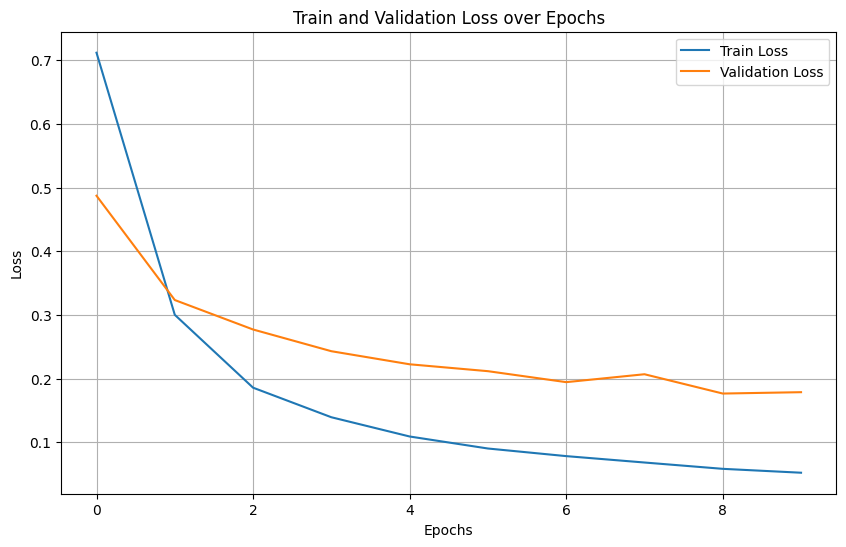

In [ ]:
# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)


In [ ]:
# Testing function
def test_model(model, test_loader, criterion, class_names):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    # Iterate over the test data
    for inputs, labels in test_loader:  # assuming you have a 'test' dataloader
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():  # Disable gradient computation for testing
            inputs = inputs.squeeze(1)
            inputs = inputs.contiguous().view(-1, 3, 96, 112)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Store predictions and labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Compute final loss and accuracy
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.show()

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average=None)  # F1-score per classe
    avg_f1 = f1_score(all_labels, all_preds, average="weighted")  # Weighted average F1-score

    # Print F1-scores
    print("\nF1 Scores per class:")
    for i, score in enumerate(f1):
        print(f"  {class_names[i]}: {score:.4f}")
    print(f"\nWeighted Average F1 Score: {avg_f1:.4f}")

Test Loss: 0.1117 Acc: 0.9710


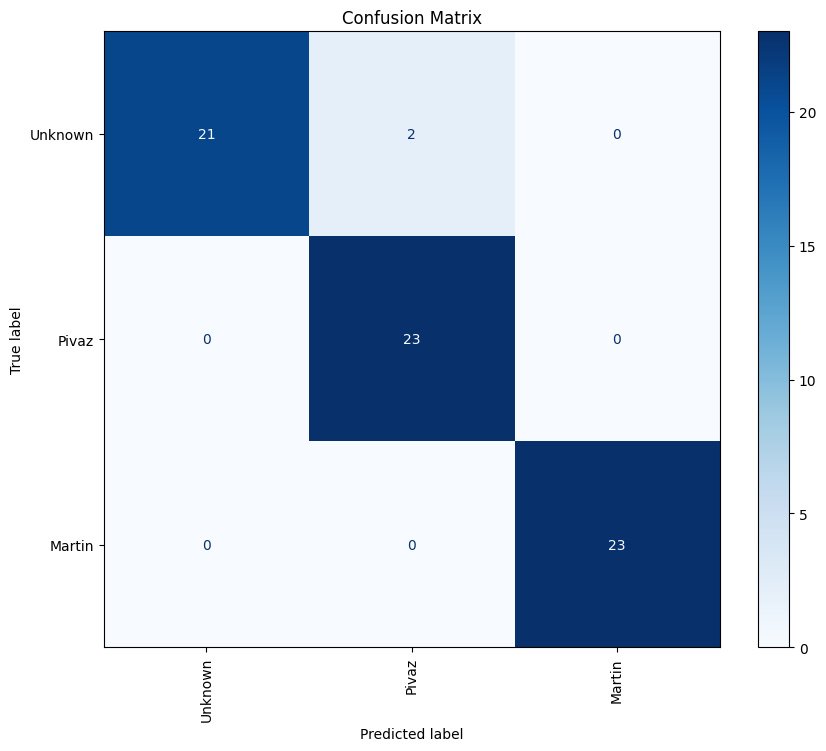


F1 Scores per class:
  Unknown: 0.9545
  Pivaz: 0.9583
  Martin: 1.0000

Weighted Average F1 Score: 0.9710


In [ ]:
test_model(model, test_loader, criterion, ['Unknown', 'Pivaz', 'Martin'])

## Additional tests

In [ ]:
martinez = '/content/drive/MyDrive/PROJECT ICT PPPP/MARTINEZ2.jpg'
pivaz = '/content/drive/MyDrive/PROJECT ICT PPPP/PIVAZ2.jpg'
unknown = '/content/drive/MyDrive/PROJECT ICT PPPP/foto sconosciuti/Rod_Blagojevich_0001.jpg'

martinez = cv2.imread(martinez)
pivaz = cv2.imread(pivaz)
unknown = cv2.imread(unknown)

martinez = preprocess_images_with_landmarks([martinez], face_detector, face_aligner)
pivaz = preprocess_images_with_landmarks([pivaz], face_detector, face_aligner)
unknown = preprocess_images_with_landmarks([unknown], face_detector, face_aligner)

In [ ]:
# Ensure the output is a single tensor
if len(martinez) > 0 and len(pivaz) > 0:  # Ensure preprocessing returned results
    martinez = martinez[0]  # Extract the single tensor
    pivaz = pivaz[0]
    unknown = unknown[0]

    # Add a batch dimension if needed
    martinez = martinez.unsqueeze(0)  # Shape: [1, 3, 96, 112]
    pivaz = pivaz.unsqueeze(0)        # Shape: [1, 3, 96, 112]
    unknown = unknown.unsqueeze(0)    # Shape: [1, 3, 96, 112]

    # Move to device
    martinez = martinez.to(device)
    pivaz = pivaz.to(device)
    unknown = unknown.to(device)

    martinez = martinez.squeeze(0).contiguous()
    pivaz = pivaz.squeeze(0).contiguous()
    unknown = unknown.squeeze(0).contiguous()

    # Pass through the model
    prob_martinez = F.softmax(model(martinez), dim=1)
    prob_pivaz = F.softmax(model(pivaz), dim=1)
    prob_unknown = F.softmax(model(unknown), dim=1)

    # Get predictions
    _, preds_martinez = torch.max(prob_martinez, 1)
    _, preds_pivaz = torch.max(prob_pivaz, 1)
    _, preds_unknown = torch.max(prob_unknown, 1)

    print(f"Martinez Prediction: {preds_martinez.item()}")
    print(f"Pivaz Prediction: {preds_pivaz.item()}")
    print(f"Unknown Prediction: {preds_unknown.item()}")

else:
    print("Preprocessing failed, no valid images detected.")

Martinez Prediction: 2
Pivaz Prediction: 1
Unknown Prediction: 0
